In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Artesia PRISM data
artesia = pd.read_csv("PPT_Artesia_NM.csv")

# Parse Date
artesia["Date"] = pd.to_datetime(artesia["Date"], format="%Y-%m")

# Convert precipitation inches → mm
artesia["Precip_mm"] = artesia["ppt (inches)"] * 25.4

# Extract year and month
artesia["Year"] = artesia["Date"].dt.year
artesia["Month"] = artesia["Date"].dt.month

artesia.head()


,Date,ppt (inches),tmean (degrees F),Precip_mm,Year,Month
0,1985-01-01,0.40,37.5,10.160,1985,1
1,1985-02-01,0.22,41.6,5.588,1985,2
2,1985-03-01,0.36,53.3,9.144,1985,3
3,1985-04-01,2.37,62.1,60.198,1985,4
4,1985-05-01,0.38,69.6,9.652,1985,5


In [2]:
summer_artesia = artesia[artesia["Month"].isin([6,7,8,9])].copy()


In [3]:
# 3-month rolling precipitation
summer_artesia["PPT_3"] = summer_artesia["Precip_mm"].rolling(3).sum()

# Historical summer baseline
mean_summer = summer_artesia["PPT_3"].mean()
std_summer  = summer_artesia["PPT_3"].std()

# Historical SPI (for reference)
summer_artesia["SPI_3"] = (summer_artesia["PPT_3"] - mean_summer) / std_summer


In [4]:
baseline_year = 2020   # adjust if needed
n_years = 100
summer_months = 4
n_points = n_years * summer_months

# Drying trend example: 10% reduction over 100 years
trend = np.linspace(1.0, 0.90, n_points)

synthetic_precip = np.random.choice(
    summer_artesia["Precip_mm"].dropna(),
    size=n_points,
    replace=True
) * trend


In [5]:
future_spi = (synthetic_precip - mean_summer) / std_summer


In [6]:
future_dates = []
year = baseline_year + 1

for _ in range(n_years):
    for m in [6,7,8,9]:
        future_dates.append(pd.Timestamp(year=year, month=m, day=1))
    year += 1

future_artesia = pd.DataFrame({
    "Date": future_dates,
    "SPI": future_spi
})

future_artesia["Year"] = future_artesia["Date"].dt.year


In [7]:
near_future_artesia = future_artesia[
    future_artesia["Year"] <= baseline_year + 50
]

middle_future_artesia = future_artesia[
    (future_artesia["Year"] > baseline_year + 50) &
    (future_artesia["Year"] <= baseline_year + 70)
]

far_future_artesia = future_artesia[
    (future_artesia["Year"] > baseline_year + 70) &
    (future_artesia["Year"] <= baseline_year + 100)
]


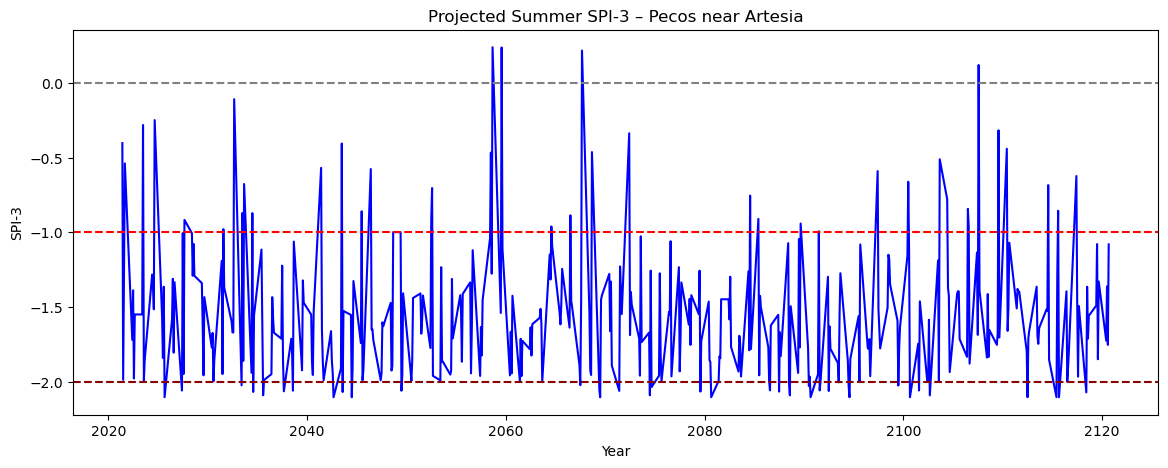

In [9]:
plt.figure(figsize=(14,5))
plt.plot(future_artesia["Date"], future_artesia["SPI"], color="blue")
plt.axhline(0, color="gray", linestyle="--")
plt.axhline(-1, color="red", linestyle="--")
plt.axhline(-2, color="darkred", linestyle="--")

plt.title("Projected Summer SPI-3 – Pecos near Artesia")
plt.ylabel("SPI-3")
plt.xlabel("Year")
plt.show()


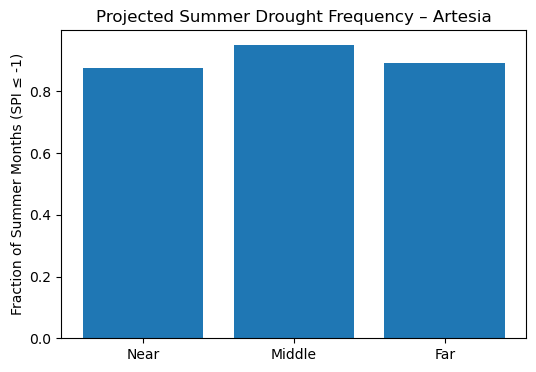

In [10]:
def drought_fraction(df):
    return (df["SPI"] <= -1).sum() / len(df)

freqs = {
    "Near": drought_fraction(near_future_artesia),
    "Middle": drought_fraction(middle_future_artesia),
    "Far": drought_fraction(far_future_artesia)
}

plt.figure(figsize=(6,4))
plt.bar(freqs.keys(), freqs.values())
plt.ylabel("Fraction of Summer Months (SPI ≤ -1)")
plt.title("Projected Summer Drought Frequency – Artesia")
plt.show()


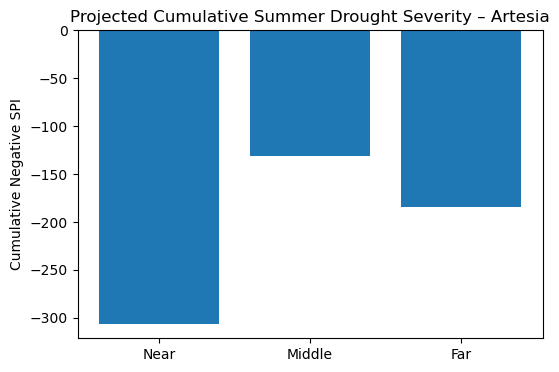

In [11]:
def cumulative_severity(df):
    return df[df["SPI"] < 0]["SPI"].sum()

sev = {
    "Near": cumulative_severity(near_future_artesia),
    "Middle": cumulative_severity(middle_future_artesia),
    "Far": cumulative_severity(far_future_artesia)
}

plt.figure(figsize=(6,4))
plt.bar(sev.keys(), sev.values())
plt.ylabel("Cumulative Negative SPI")
plt.title("Projected Cumulative Summer Drought Severity – Artesia")
plt.show()
